In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [20]:
# Visualize pairs of hyperparameters using pairplot
warnings.filterwarnings("ignore", message="The figure layout has changed to tight", module="seaborn.axisgrid")

# Loading the dataset
data = pd.read_csv('household_power_consumption.csv')

# Converting 'Date' column to datetime type
data['Date'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)

# Ensuring numeric values in relevant columns
numeric_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Removing rows with missing values
data.dropna(inplace=True)

# Aggregating data as a daily average
daily_data = data.groupby(data['Date'].dt.date).agg({
    'Global_active_power': 'mean',
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'mean',
    'Sub_metering_2': 'mean',
    'Sub_metering_3': 'mean'
}).reset_index()

# Extracting year, month, and day features
daily_data['Year'] = pd.to_datetime(daily_data['Date']).dt.year
daily_data['Month'] = pd.to_datetime(daily_data['Date']).dt.month
daily_data['Day'] = pd.to_datetime(daily_data['Date']).dt.day
daily_data['DayOfWeek'] = pd.to_datetime(daily_data['Date']).dt.dayofweek

# Dropping the original 'Date' column
daily_data.drop(columns=['Date'], inplace=True)


#results = pd.DataFrame(grid_search.cv_results_)
#sns.pairplot(results[['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score']])

#plt.gcf().set_size_inches(12, 12)

#plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.2, wspace=0.2)

# Show the plot
#plt.show()


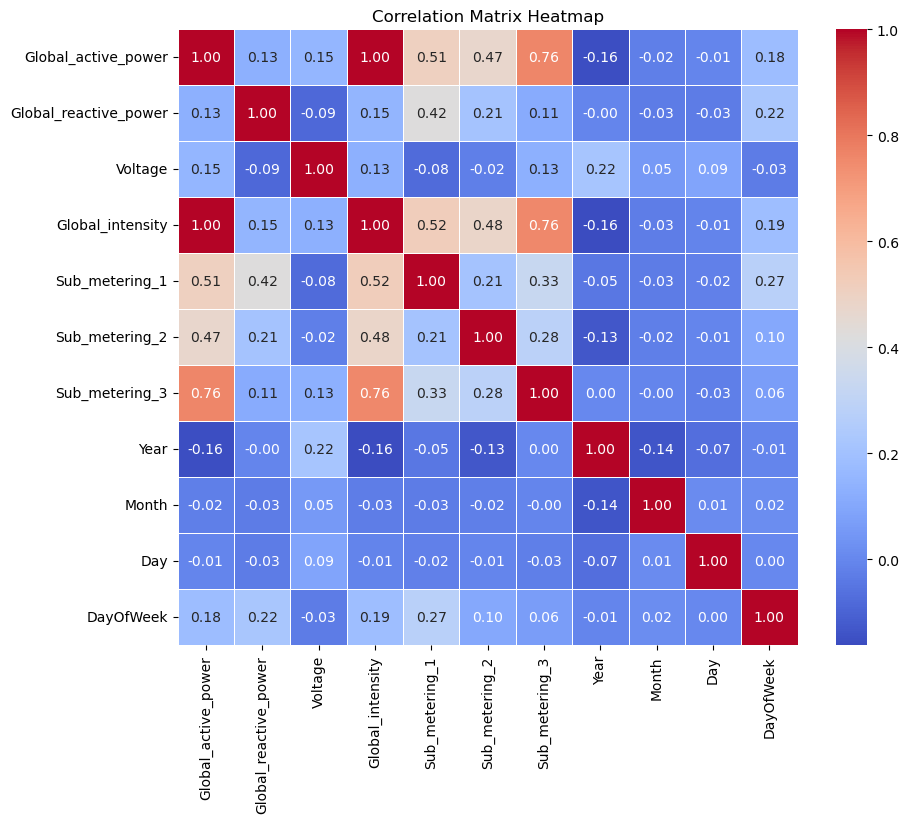

In [21]:
# Calculate the correlation matrix of all the daily average values
corr_matrix = daily_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

This is the heatmap that shows the correlation for all the combinations of the daily averages for two variables. This is nessasary because these were used as independent variables when making a prediction using random forest variables. Based on the correlation matrix Global active power vs Sub Metering 3 has a strong correlations as well as Global Intensity vs Sub Metering 3. That also means we will look in to the prediction using random forest regression to see the predictions of Global active power, Global Intensity and Sub Metering 3. 

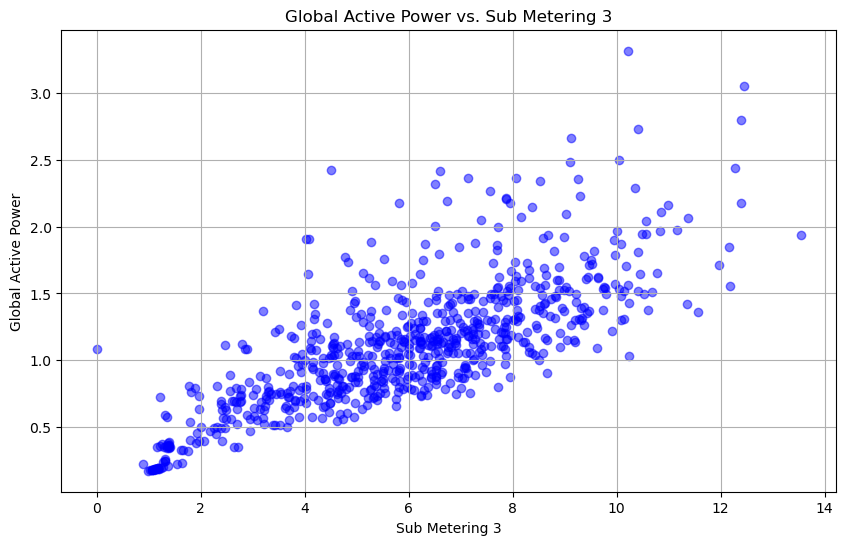

In [22]:
plt.figure(figsize=(10, 6))

# Scatter plot of Global Active Power vs. Sub Metering 3
plt.scatter(daily_data['Sub_metering_3'], daily_data['Global_active_power'], color='blue', alpha=0.5)

plt.title('Global Active Power vs. Sub Metering 3')
plt.ylabel('Global Active Power')
plt.xlabel('Sub Metering 3')
plt.grid(True)
plt.show()

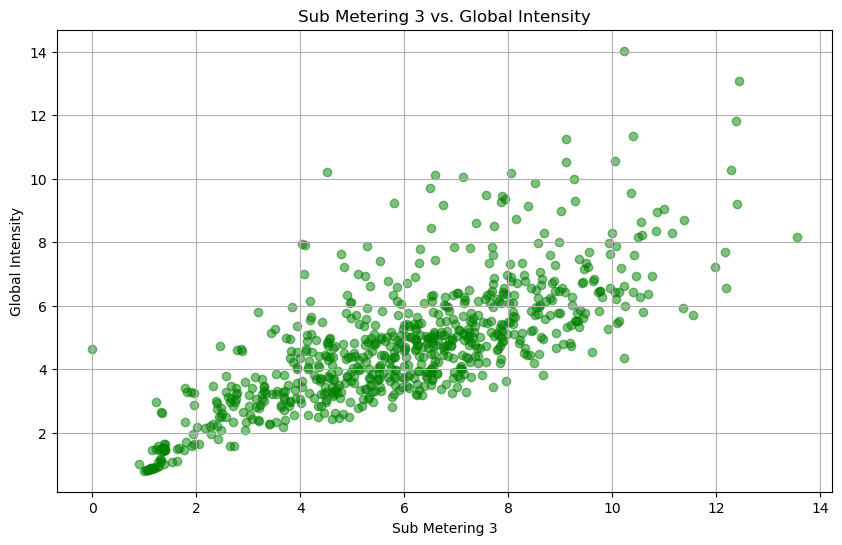

In [23]:
plt.figure(figsize=(10, 6))

# Scatter plot of Sub Metering 3 vs. Global Intensity
plt.scatter(daily_data['Sub_metering_3'], daily_data['Global_intensity'], color='green', alpha=0.5)

plt.title('Sub Metering 3 vs. Global Intensity')
plt.xlabel('Sub Metering 3')
plt.ylabel('Global Intensity')
plt.grid(True)
plt.show()

In [24]:
# Splitting data into features (X) and target (y)
X = daily_data[['Year', 'Month', 'Day', 'DayOfWeek', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
y = daily_data['Global_active_power']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


In [25]:
# Hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search with Random Forest Regressor
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters found:")
print(grid_search.best_params_)

# Predictions and error metrics
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mean_actual = y_test.mean()
rae = np.mean(np.abs(y_test - y_pred)) / np.mean(np.abs(y_test - mean_actual))
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Relative Absolute Error (RAE): {rae}")


Best parameters found:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean Squared Error (MSE): 0.020595891617161903
Root Mean Squared Error (RMSE): 0.14351268800061515
Relative Absolute Error (RAE): 0.15676033580626217


In [26]:
data = pd.read_csv('household_power_consumption.csv')

# Convert 'Date' column to datetime type
data['Date'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)

# Makes sure the columns contain numeric values
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')
data['Global_reactive_power'] = pd.to_numeric(data['Global_reactive_power'], errors='coerce')
data['Voltage'] = pd.to_numeric(data['Voltage'], errors='coerce')
data['Global_intensity'] = pd.to_numeric(data['Global_intensity'], errors='coerce')
data['Sub_metering_1'] = pd.to_numeric(data['Sub_metering_1'], errors='coerce')
data['Sub_metering_2'] = pd.to_numeric(data['Sub_metering_2'], errors='coerce')
data['Sub_metering_3'] = pd.to_numeric(data['Sub_metering_3'], errors='coerce')

# Remove rows that has missing values
data.dropna(inplace=True)

# This Aggregate data as a daily average
daily_data = data.groupby(data['Date'].dt.date).agg({
    'Global_active_power': 'mean',
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'mean',
    'Sub_metering_2': 'mean',
    'Sub_metering_3': 'mean'
}).reset_index()

# Extract year, month, and day features
daily_data['Year'] = pd.to_datetime(daily_data['Date']).dt.year
daily_data['Month'] = pd.to_datetime(daily_data['Date']).dt.month
daily_data['Day'] = pd.to_datetime(daily_data['Date']).dt.day
daily_data['DayOfWeek'] = pd.to_datetime(daily_data['Date']).dt.dayofweek


# Drop the original 'Date' column
daily_data.drop(columns=['Date'], inplace=True)

# Split data into features (X) and target (y)
X = daily_data[['Year', 'Month', 'Day', 'DayOfWeek', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
y = daily_data['Global_active_power']

# Split the data into training and testing sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# hyperparameter grid definition appropriate for Random Forest Regression
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest Regressor for prediction
rf = RandomForestRegressor()

# Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Prediction
y_pred = grid_search.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
mean_actual = y_test.mean()
rae = np.mean(np.abs(y_test - y_pred)) / np.mean(np.abs(y_test - mean_actual))
print("Relative Absolute Error (RAE):", rae)

Best parameters found:
{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean Squared Error (MSE): 0.018229484031113193
Root Mean Squared Error (RMSE): 0.1350166065012493
Relative Absolute Error (RAE): 0.14901208215677844


This is the output show the hyperparameter values used for the grid search and it shows the Mean Squared Error was the smallest, compared to Root Mean Squared Error and Relative Absolute Error, but they all had very small errors. The test split test size was 50%.

Cross-Validated MSE RF: 0.018769885122855847


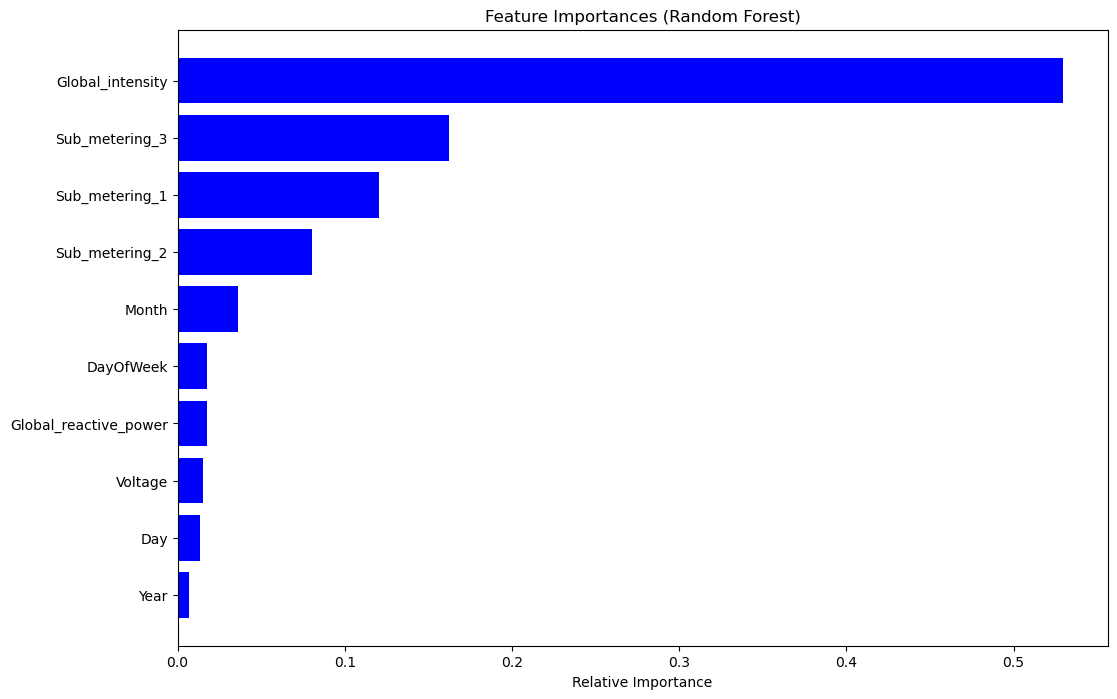

In [27]:
# Cross-Validation
scores_rf = cross_val_score(grid_search.best_estimator_, X, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validated MSE RF:", -scores_rf.mean())

# Visualization of feature importances for Random Forest
importances = grid_search.best_estimator_.feature_importances_
features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.title('Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


Based on the feature impornats for global active power, global intensity and sum metering 3 has the highest importance which also explains why those variables have the strongest correlation with each other. 

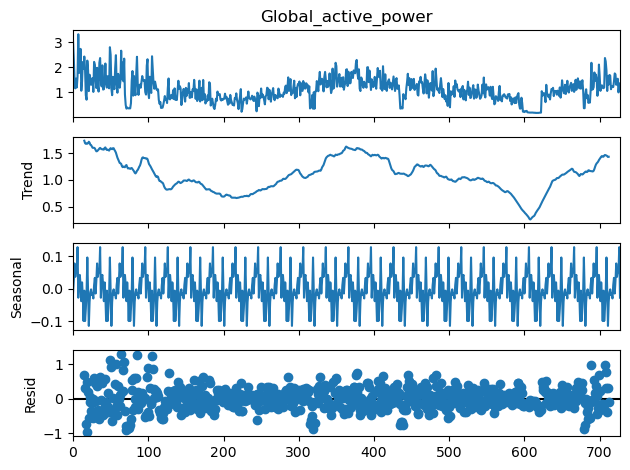

In [28]:
# Seasonal decomposition
decomposition = seasonal_decompose(daily_data['Global_active_power'], model='additive', period=30)
decomposition.plot()
plt.show()

The season decomposition shows how seasonal global active power is as we see during the time frame from late 2006 to late 2008 that the usage of the power is higher during winter and lower during summer. 

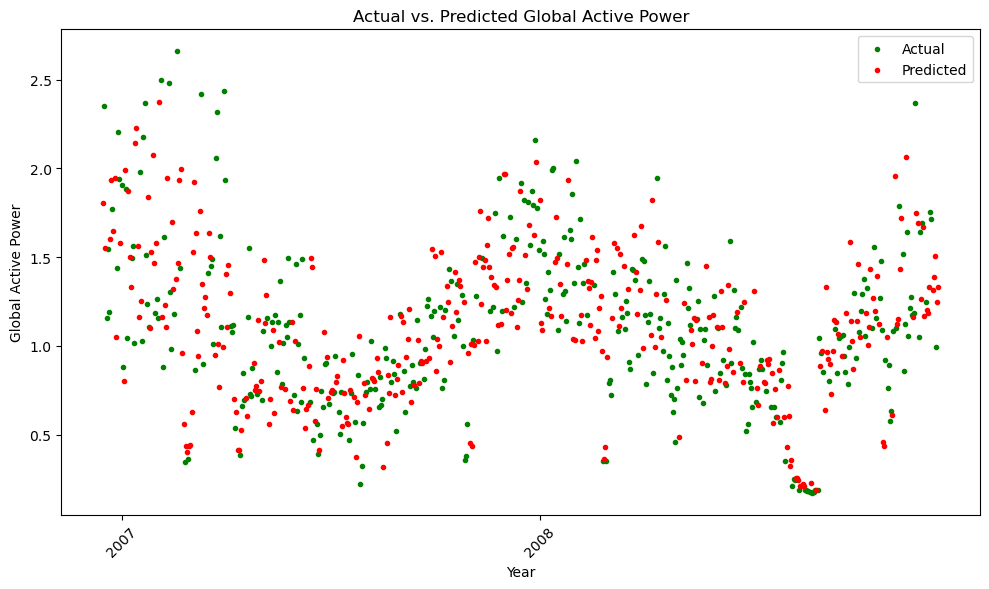

In [29]:
# Visualization that shows both the actual and predicted values. 
plt.figure(figsize=(10, 6))

plt.scatter(X_train.index, y_train, label='Actual', marker='.', color='green')

plt.scatter(X_test.index, y_pred, label='Predicted', marker='.', color='red')

# Customize x-axis labels to show only the years 2007 and 2008
tick_locations = []
tick_labels = []
for index, row in daily_data.iterrows():
    if row['Year'] == 2007 and row['Month'] == 1 and row['Day'] == 1:  
        tick_locations.append(index)
        tick_labels.append('2007')  
    elif row['Year'] == 2008 and row['Month'] == 1 and row['Day'] == 1: 
        tick_locations.append(index)
        tick_labels.append('2008')  

plt.xticks(tick_locations, tick_labels, rotation=45)

plt.title('Actual vs. Predicted Global Active Power')
plt.xlabel('Year')
plt.ylabel('Global Active Power')
plt.legend()
plt.tight_layout()
plt.show()

This graph shows the Global Active Power with the daily average throughout the two years. It shows that actual which is the green dots and the predicted is the red dot. The difference between the actual and predicted using Random Forest Regression with multiple regression using independent values are Year, Month, Day, and the daily averages for Global_reactive_power, Voltage, Global_intensity, Sub_metering_1, Sub_metering_2, and Sub_metering_3. The dependent variable is the daily average for Global_active_power.

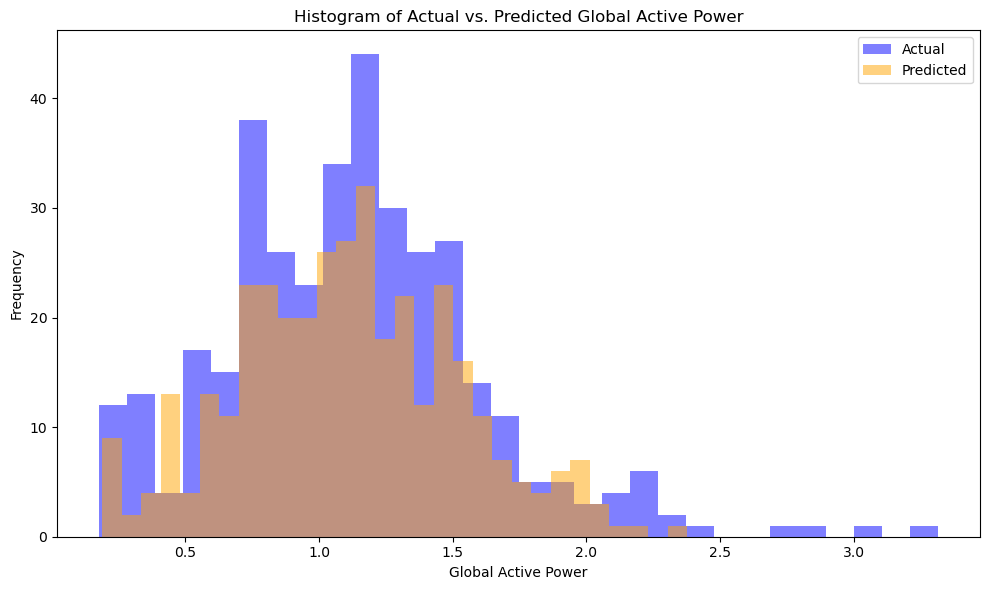

In [30]:
# Visualization: Histograms of Actual and Predicted Global Active Power
plt.figure(figsize=(10, 6))

plt.hist(y_test, bins=30, alpha=0.5, color='blue', label='Actual')

plt.hist(y_pred, bins=30, alpha=0.5, color='orange', label='Predicted')

plt.title('Histogram of Actual vs. Predicted Global Active Power')
plt.xlabel('Global Active Power')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

This is the histogram between the actual and predicted values for the daily average of the global active power and the frequency is higher between when the global active power is between 1.0 -1.5.

This is the pairplot to show the comparisions of pairs for the hyperplot.



In [32]:
#data = pd.read_csv('household_power_consumption.csv')
# Convert 'Date' column to datetime type
#data['Date'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)

# Makes sure the columns contain numeric values
#data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')
#data['Global_reactive_power'] = pd.to_numeric(data['Global_reactive_power'], errors='coerce')
#data['Voltage'] = pd.to_numeric(data['Voltage'], errors='coerce')
#data['Global_intensity'] = pd.to_numeric(data['Global_intensity'], errors='coerce')
#data['Sub_metering_1'] = pd.to_numeric(data['Sub_metering_1'], errors='coerce')
#data['Sub_metering_2'] = pd.to_numeric(data['Sub_metering_2'], errors='coerce')
#data['Sub_metering_3'] = pd.to_numeric(data['Sub_metering_3'], errors='coerce')

# Remove rows that has missing values
#data.dropna(inplace=True)

# This Aggregate data as a daily average
#daily_data = data.groupby(data['Date'].dt.date).agg({
#    'Global_active_power': 'mean',
#    'Global_reactive_power': 'mean',
#    'Voltage': 'mean',
#    'Global_intensity': 'mean',
#    'Sub_metering_1': 'mean',
#    'Sub_metering_2': 'mean',
#    'Sub_metering_3': 'mean'
#}).reset_index()

# Extract year, month, and day features
#daily_data['Year'] = pd.to_datetime(daily_data['Date']).dt.year
#daily_data['Month'] = pd.to_datetime(daily_data['Date']).dt.month
#daily_data['Day'] = pd.to_datetime(daily_data['Date']).dt.day

# Drop the original 'Date' column
#daily_data.drop(columns=['Date'], inplace=True)

# Split data into features (X_reactive) and target (y_reactive) for Global Intensity prediction
X_reactive = daily_data[['Year', 'Month', 'Day', 'DayOfWeek', 'Global_reactive_power', 'Voltage', 'Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
y_reactive = daily_data['Global_intensity']

# Split the data into training and testing sets
X_train_reactive, X_test_reactive, y_train_reactive, y_test_reactive = train_test_split(X_reactive, y_reactive, test_size=0.5, random_state=42)

# Grid Search with Random Forest Regressor
grid_search_reactive = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)
grid_search_reactive.fit(X_train_reactive, y_train_reactive)

# Best parameters found
print("Best parameters found for Global Intensity prediction:")
print(grid_search_reactive.best_params_)

# Predictions and error metrics
y_pred_reactive = grid_search_reactive.predict(X_test_reactive)
mse_reactive = mean_squared_error(y_test_reactive, y_pred_reactive)
rmse_reactive = np.sqrt(mse_reactive)
mean_actual_reactive = y_test_reactive.mean()
rae_reactive = np.mean(np.abs(y_test_reactive - y_pred_reactive)) / np.mean(np.abs(y_test_reactive - mean_actual_reactive))
print(f"Mean Squared Error (MSE): {mse_reactive}")
print(f"Root Mean Squared Error (RMSE): {rmse_reactive}")
print(f"Relative Absolute Error (RAE): {rae_reactive}")


Best parameters found for Global Intensity prediction:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Squared Error (MSE): 0.33490255058850965
Root Mean Squared Error (RMSE): 0.578707655546831
Relative Absolute Error (RAE): 0.1541201046071434


Cross-Validated MSE RF: 0.3205821021714709


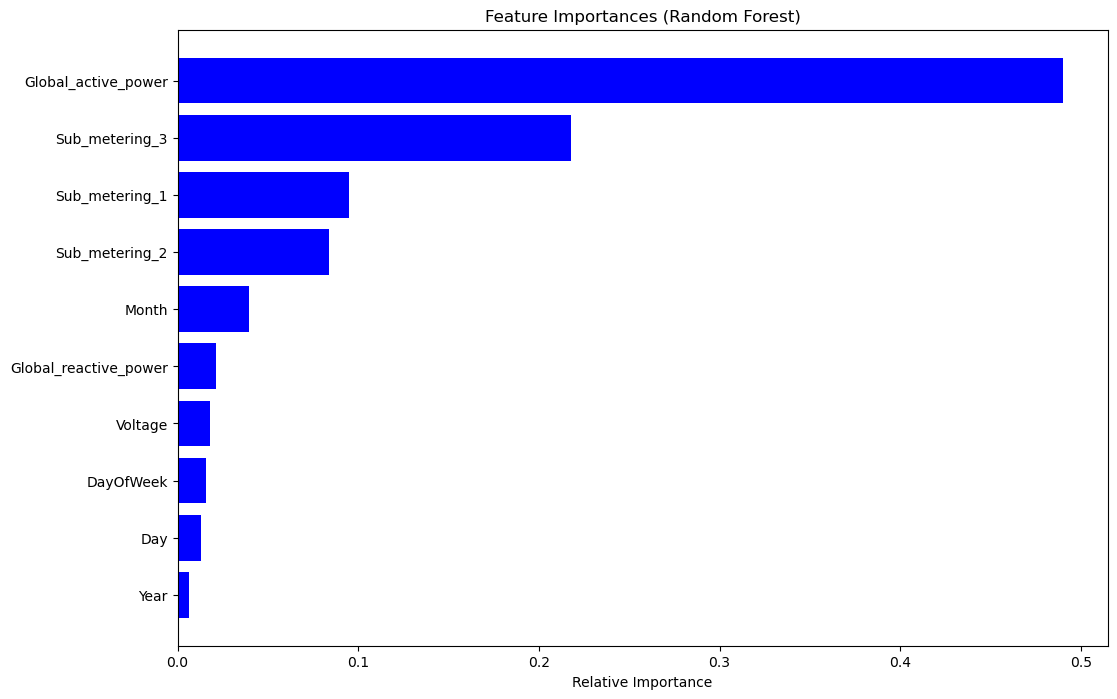

In [33]:
# Cross-Validation
scores_rf = cross_val_score(grid_search_reactive.best_estimator_, X_reactive, y_reactive, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validated MSE RF:", -scores_rf.mean())

# Visualization of feature importances for Random Forest
importances = grid_search_reactive.best_estimator_.feature_importances_
features = X_reactive.columns
indices = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.title('Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

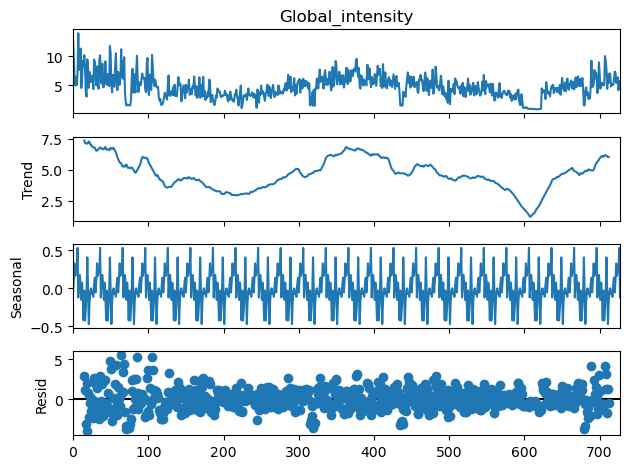

In [34]:
# Seasonal decomposition
decomposition = seasonal_decompose(daily_data['Global_intensity'], model='additive', period=30)
decomposition.plot()
plt.show()

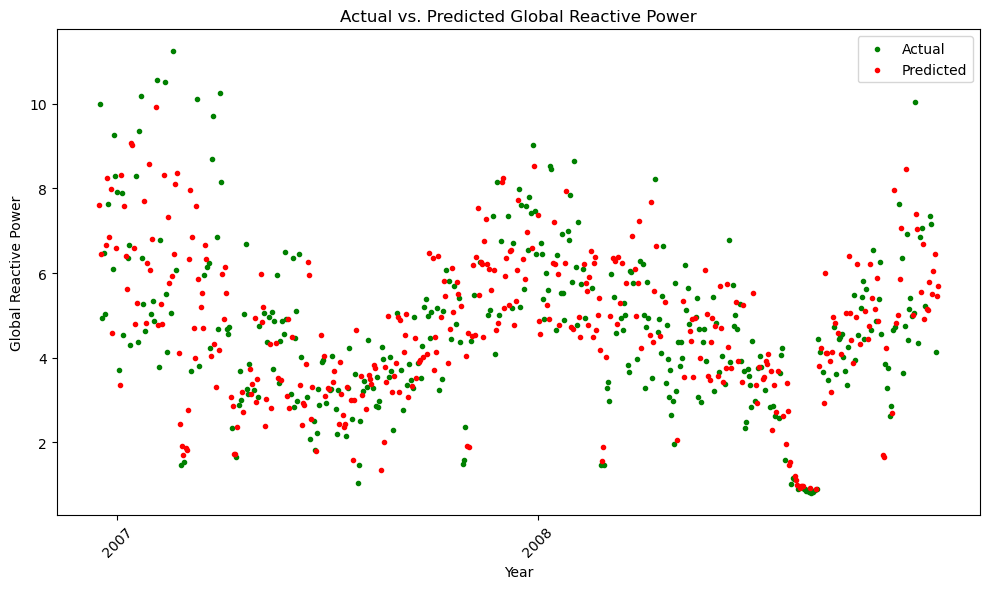

In [37]:
# Visualization that shows both the actual and predicted values. 
plt.figure(figsize=(10, 6))

plt.scatter(X_train_reactive.index, y_train_reactive, label='Actual', marker='.', color='green')

plt.scatter(X_test_reactive.index, y_pred_reactive, label='Predicted', marker='.', color='red')

# Customize x-axis labels to show only the years 2007 and 2008
tick_locations = []
tick_labels = []
for index, row in daily_data.iterrows():
    if row['Year'] == 2007 and row['Month'] == 1 and row['Day'] == 1:  
        tick_locations.append(index)
        tick_labels.append('2007')  
    elif row['Year'] == 2008 and row['Month'] == 1 and row['Day'] == 1: 
        tick_locations.append(index)
        tick_labels.append('2008')  

plt.xticks(tick_locations, tick_labels, rotation=45)

plt.title('Actual vs. Predicted Global Reactive Power')
plt.xlabel('Year')
plt.ylabel('Global Reactive Power')
plt.legend()
plt.tight_layout()
plt.show()

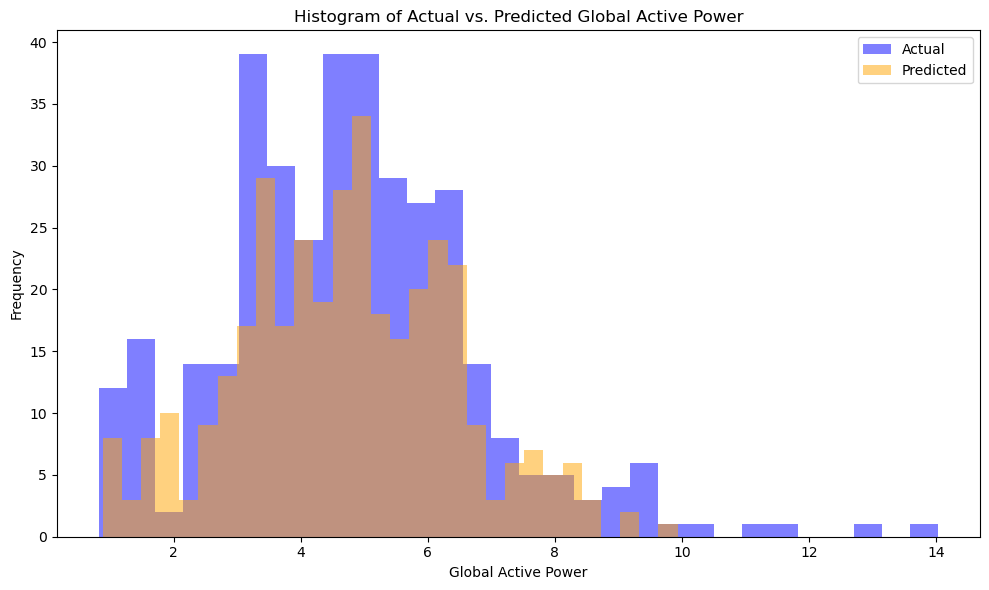

In [35]:
# Visualization: Histograms of Actual and Predicted Global Active Power
plt.figure(figsize=(10, 6))

plt.hist(y_test_reactive, bins=30, alpha=0.5, color='blue', label='Actual')

plt.hist(y_pred_reactive, bins=30, alpha=0.5, color='orange', label='Predicted')

plt.title('Histogram of Actual vs. Predicted Global Active Power')
plt.xlabel('Global Active Power')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

This is the histogram between the actual and predicted values for the daily average of the global active power and the frequency is higher between when the global active power is between 0.10 - 0.135

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

data = pd.read_csv('household_power_consumption.csv')

# Convert 'Date' column to datetime type
data['Date'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)

# Makes sure the columns contain numeric values
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')
data['Global_reactive_power'] = pd.to_numeric(data['Global_reactive_power'], errors='coerce')
data['Voltage'] = pd.to_numeric(data['Voltage'], errors='coerce')
data['Global_intensity'] = pd.to_numeric(data['Global_intensity'], errors='coerce')
data['Sub_metering_1'] = pd.to_numeric(data['Sub_metering_1'], errors='coerce')
data['Sub_metering_2'] = pd.to_numeric(data['Sub_metering_2'], errors='coerce')
data['Sub_metering_3'] = pd.to_numeric(data['Sub_metering_3'], errors='coerce')

# Remove rows that has missing values
data.dropna(inplace=True)

# This Aggregate data as a daily average
daily_data = data.groupby(data['Date'].dt.date).agg({
    'Global_active_power': 'mean',
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'mean',
    'Sub_metering_2': 'mean',
    'Sub_metering_3': 'mean'
}).reset_index()

# Extract year, month, and day features
daily_data['Year'] = pd.to_datetime(daily_data['Date']).dt.year
daily_data['Month'] = pd.to_datetime(daily_data['Date']).dt.month
daily_data['Day'] = pd.to_datetime(daily_data['Date']).dt.day

# Drop the original 'Date' column
daily_data.drop(columns=['Date'], inplace=True)

# Split data into features (X) and target (y)
X_intensity = daily_data[['Year', 'Month', 'Day', 'Global_active_power', 'Voltage', 'Global_reactive_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
y_intensity = daily_data['Global_intensity']

# Split the data into training and testing sets using train_test_split
X_train_intensity, X_test_intensity, y_train_intensity, y_test_intensity = train_test_split(X_intensity, y_intensity, test_size=0.5, random_state=42)

# hyperparameter grid definition appropriate for Random Forest Regression
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest Regressor for prediction
rf = RandomForestRegressor()

# Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search model
grid_search.fit(X_train_intensity, y_train_intensity)

# Best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Prediction
y_pred_intensity = grid_search.predict(X_test_intensity)

mse_intensity = mean_squared_error(y_test_intensity, y_pred_intensity)
print("Mean Squared Error (MSE):", mse_intensity)
rmse_intensity = np.sqrt(mse_intensity)
print("Root Mean Squared Error (RMSE):", rmse_intensity)
mean_actual_intensity = y_test_intensity.mean()
rae_intensity = np.mean(np.abs(y_test_intensity - y_pred_intensity)) / np.mean(np.abs(y_test_intensity - mean_actual_intensity))
print("Relative Absolute Error (RAE):", rae_intensity)

Best parameters found:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error (MSE): 0.3538416635581118
Root Mean Squared Error (RMSE): 0.5948459158119116
Relative Absolute Error (RAE): 0.16438311712054685


Cross-Validated MSE RF: 0.2818695694088036


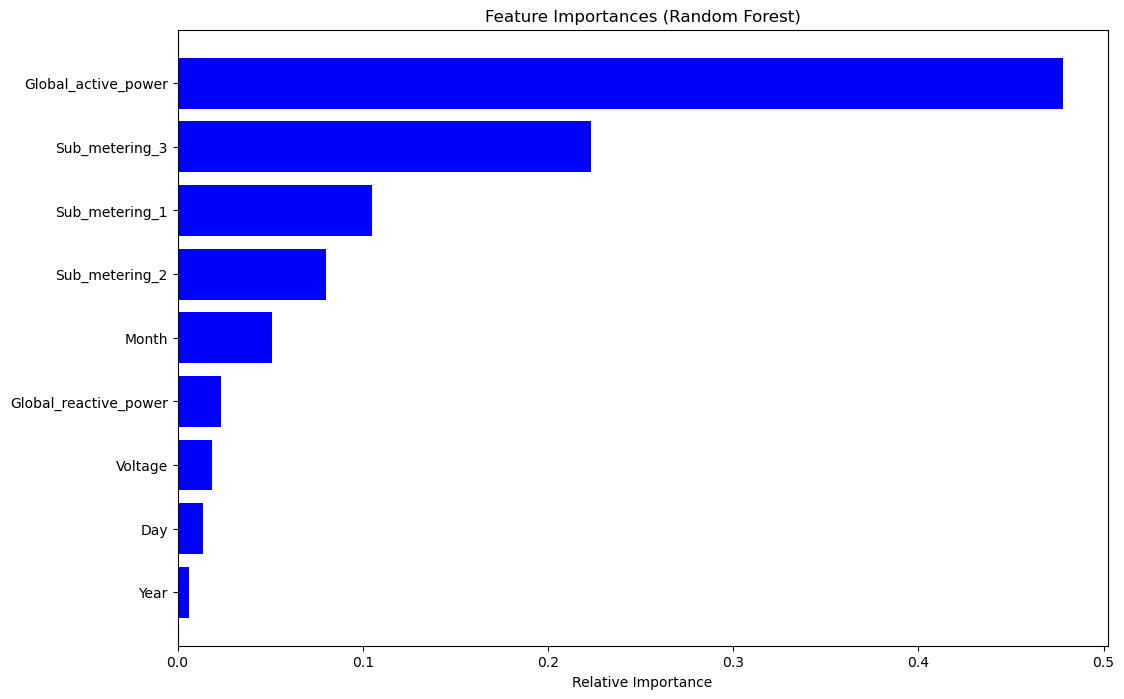

In [31]:
# Cross-Validation
scores_rf = cross_val_score(grid_search.best_estimator_, X_intensity, y_intensity, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validated MSE RF:", -scores_rf.mean())

# Visualization of feature importances for Random Forest
importances = grid_search.best_estimator_.feature_importances_
features = X_intensity.columns
indices = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.title('Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

For global intensity it shows global active power and sub metering 3 with the two higher relative importance and those two as have a strong correlation with each other. 

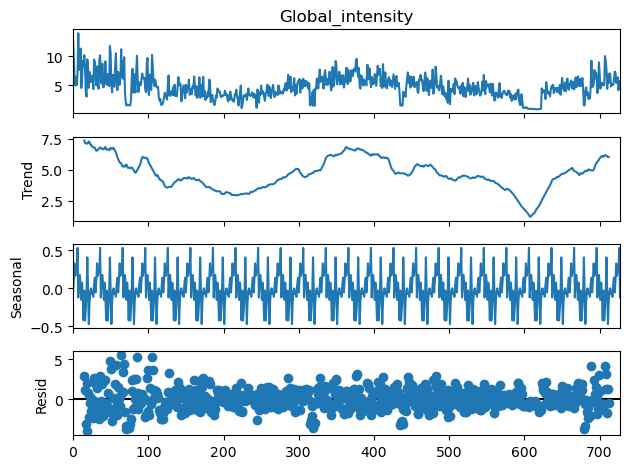

In [32]:
# Seasonal decomposition
decomposition = seasonal_decompose(daily_data['Global_intensity'], model='additive', period=30)
decomposition.plot()
plt.show()

The global intensity is seasonal since it uses higher global intensity in the winter and lower during the summer. 

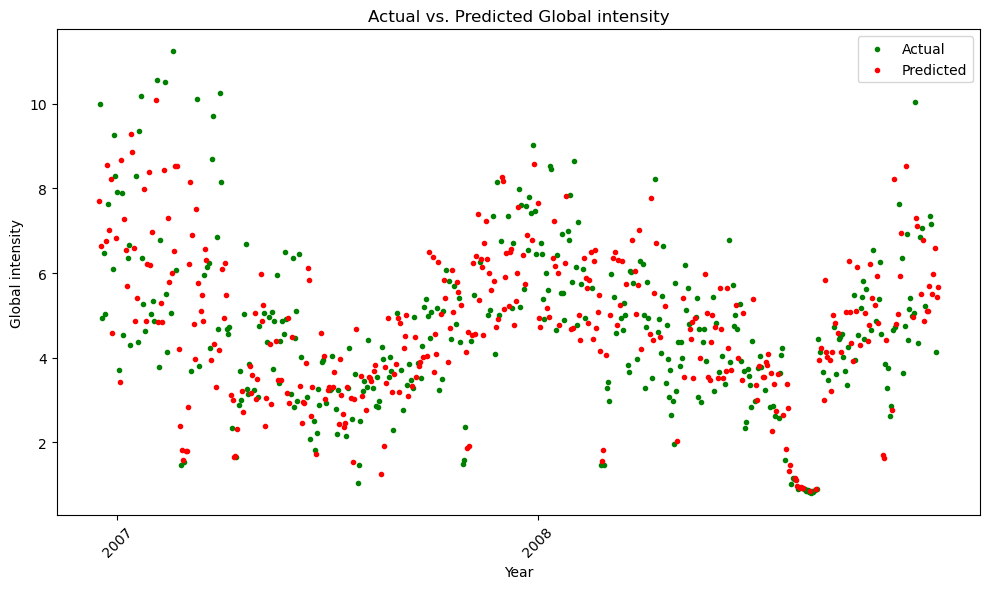

In [33]:
# Visualization that shows both the actual and predicted values. 
plt.figure(figsize=(10, 6))

plt.scatter(X_train_intensity.index, y_train_intensity, label='Actual', marker='.', color='green')

plt.scatter(X_test_intensity.index, y_pred_intensity, label='Predicted', marker='.', color='red')

# Customize x-axis labels to show only the years 2007 and 2008
tick_locations = []
tick_labels = []
for index, row in daily_data.iterrows():
    if row['Year'] == 2007 and row['Month'] == 1 and row['Day'] == 1:  
        tick_locations.append(index)
        tick_labels.append('2007')  
    elif row['Year'] == 2008 and row['Month'] == 1 and row['Day'] == 1: 
        tick_locations.append(index)
        tick_labels.append('2008')  

plt.xticks(tick_locations, tick_labels, rotation=45)

plt.title('Actual vs. Predicted Global intensity')
plt.xlabel('Year')
plt.ylabel('Global intensity')
plt.legend()
plt.tight_layout()
plt.show()

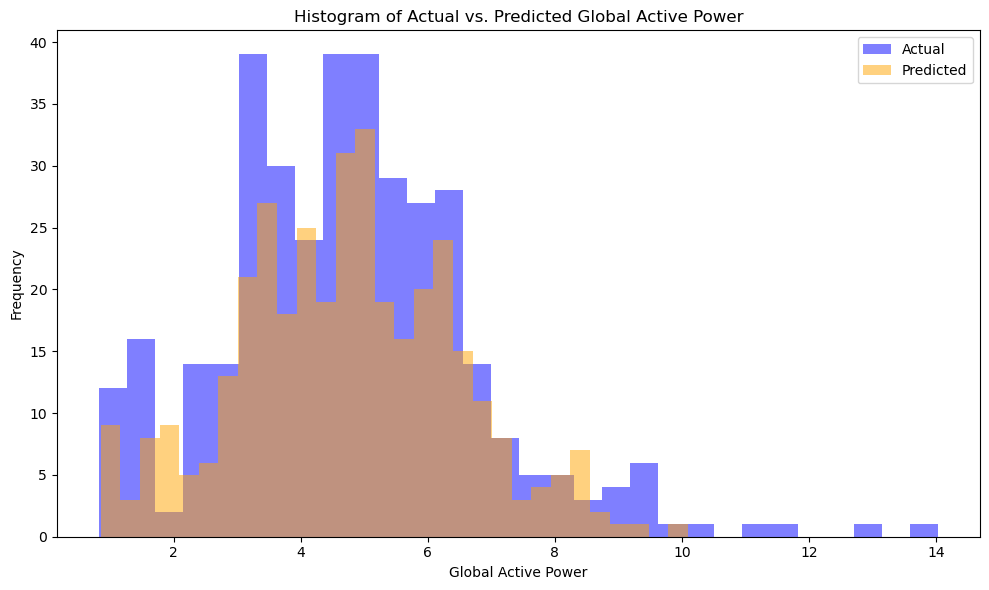

In [34]:
# Visualization: Histograms of Actual and Predicted Global Active Power
plt.figure(figsize=(10, 6))

plt.hist(y_test_intensity, bins=30, alpha=0.5, color='blue', label='Actual')

plt.hist(y_pred_intensity, bins=30, alpha=0.5, color='orange', label='Predicted')

plt.title('Histogram of Actual vs. Predicted Global Active Power')
plt.xlabel('Global Active Power')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

This is the histogram between the actual and predicted values for the daily average of the global active power and the frequency is higher between when the global active power is between 2 - 8.

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

data = pd.read_csv('household_power_consumption.csv')

# Convert 'Date' column to datetime type
data['Date'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)

# Makes sure the columns contain numeric values
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')
data['Global_reactive_power'] = pd.to_numeric(data['Global_reactive_power'], errors='coerce')
data['Voltage'] = pd.to_numeric(data['Voltage'], errors='coerce')
data['Global_intensity'] = pd.to_numeric(data['Global_intensity'], errors='coerce')
data['Sub_metering_1'] = pd.to_numeric(data['Sub_metering_1'], errors='coerce')
data['Sub_metering_2'] = pd.to_numeric(data['Sub_metering_2'], errors='coerce')
data['Sub_metering_3'] = pd.to_numeric(data['Sub_metering_3'], errors='coerce')

# Remove rows that has missing values
data.dropna(inplace=True)

# This Aggregate data as a daily average
daily_data = data.groupby(data['Date'].dt.date).agg({
    'Global_active_power': 'mean',
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'mean',
    'Sub_metering_2': 'mean',
    'Sub_metering_3': 'mean'
}).reset_index()

# Extract year, month, and day features
daily_data['Year'] = pd.to_datetime(daily_data['Date']).dt.year
daily_data['Month'] = pd.to_datetime(daily_data['Date']).dt.month
daily_data['Day'] = pd.to_datetime(daily_data['Date']).dt.day

# Drop the original 'Date' column
daily_data.drop(columns=['Date'], inplace=True)

# Split data into features (X) and target (y)
X_metering = daily_data[['Year', 'Month', 'Day', 'Global_active_power', 'Global_intensity', 'Voltage', 'Global_reactive_power', 'Sub_metering_1', 'Sub_metering_2']]
y_metering = daily_data['Sub_metering_3']

# Split the data into training and testing sets using train_test_split
X_train_metering, X_test_metering, y_train_metering, y_test_metering = train_test_split(X_metering, y_metering, test_size=0.5, random_state=42)

# hyperparameter grid definition appropriate for Random Forest Regression
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest Regressor for prediction
rf = RandomForestRegressor()

# Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search model
grid_search.fit(X_train_metering, y_train_metering)

# Best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Prediction
y_pred_metering = grid_search.predict(X_test_metering)

mse_metering = mean_squared_error(y_test_metering, y_pred_metering)
print("Mean Squared Error (MSE):", mse_metering)
rmse_metering = np.sqrt(mse_metering)
print("Root Mean Squared Error (RMSE):", rmse_metering)
mean_actual_metering = y_test_metering.mean()
rae_metering = np.mean(np.abs(y_test_metering - y_pred_metering)) / np.mean(np.abs(y_test_metering - mean_actual_metering))
print("Relative Absolute Error (RAE):", rae_metering)

Best parameters found:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Mean Squared Error (MSE): 2.3712288642855777
Root Mean Squared Error (RMSE): 1.5398794966767944
Relative Absolute Error (RAE): 0.568994173613962


Cross-Validated MSE RF: 2.339342396613075


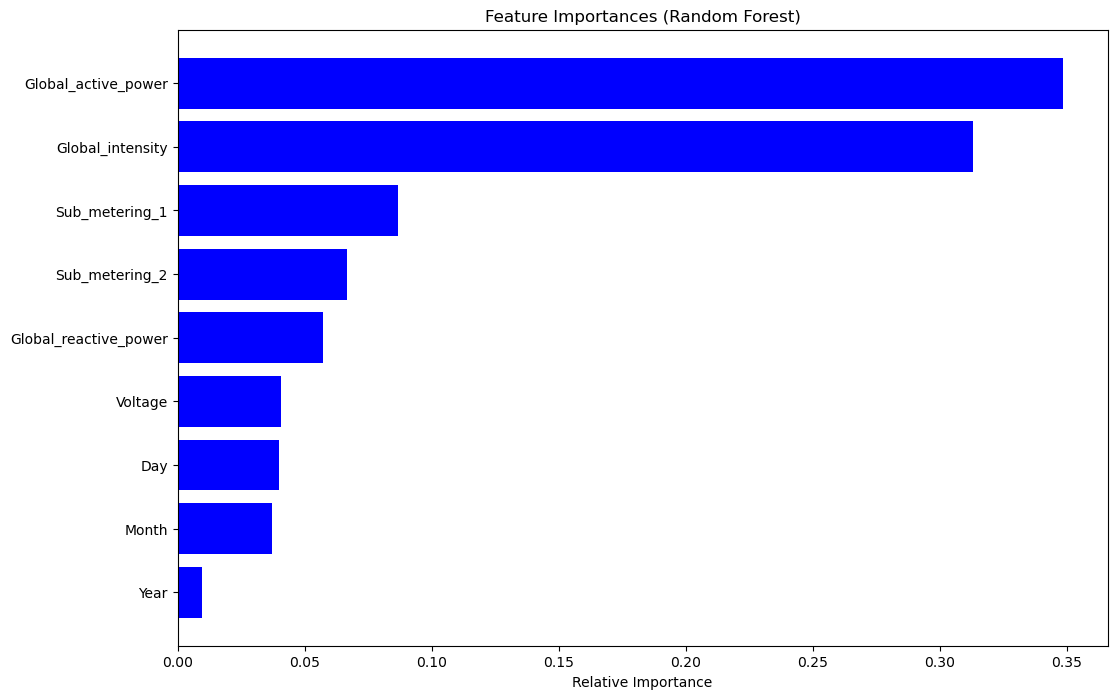

In [40]:
# Cross-Validation
scores_rf = cross_val_score(grid_search.best_estimator_, X_metering, y_metering, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validated MSE RF:", -scores_rf.mean())

# Visualization of feature importances for Random Forest
importances = grid_search.best_estimator_.feature_importances_
features = X_metering.columns
indices = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.title('Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

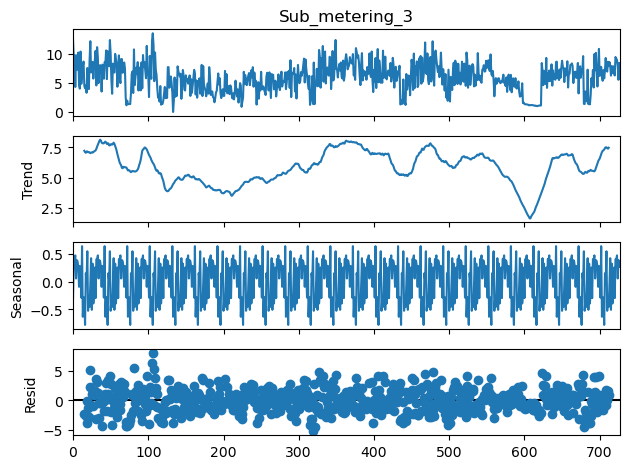

In [41]:
# Seasonal decomposition
decomposition = seasonal_decompose(daily_data['Sub_metering_3'], model='additive', period=30)
decomposition.plot()
plt.show()

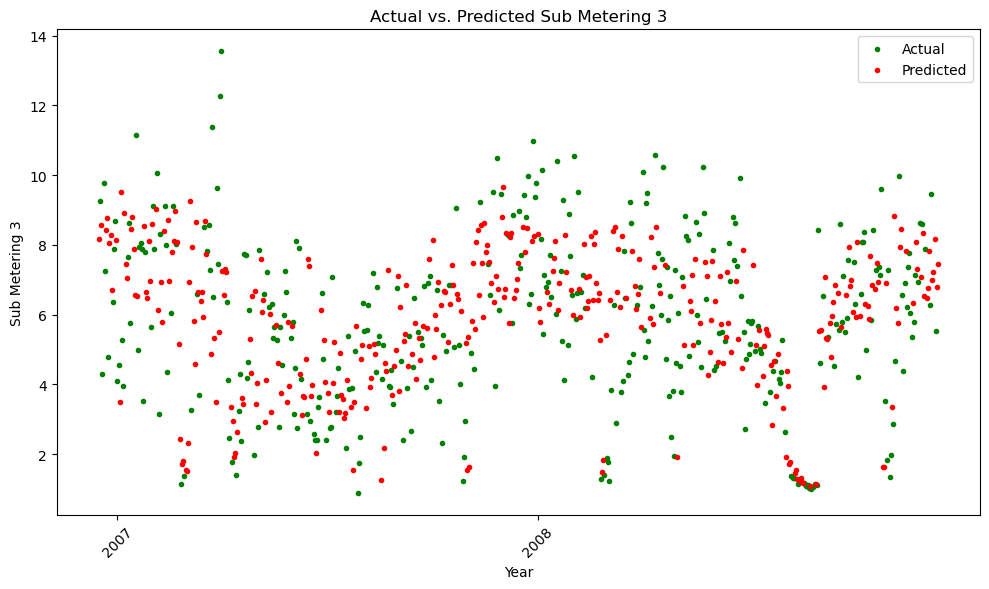

In [42]:
# Visualization that shows both the actual and predicted values. 
plt.figure(figsize=(10, 6))

plt.scatter(X_train_metering.index, y_train_metering, label='Actual', marker='.', color='green')

plt.scatter(X_test_metering.index, y_pred_metering, label='Predicted', marker='.', color='red')

# Customize x-axis labels to show only the years 2007 and 2008
tick_locations = []
tick_labels = []
for index, row in daily_data.iterrows():
    if row['Year'] == 2007 and row['Month'] == 1 and row['Day'] == 1:  
        tick_locations.append(index)
        tick_labels.append('2007')  
    elif row['Year'] == 2008 and row['Month'] == 1 and row['Day'] == 1: 
        tick_locations.append(index)
        tick_labels.append('2008')  

plt.xticks(tick_locations, tick_labels, rotation=45)

plt.title('Actual vs. Predicted Sub Metering 3')
plt.xlabel('Year')
plt.ylabel('Sub Metering 3')
plt.legend()
plt.tight_layout()
plt.show()

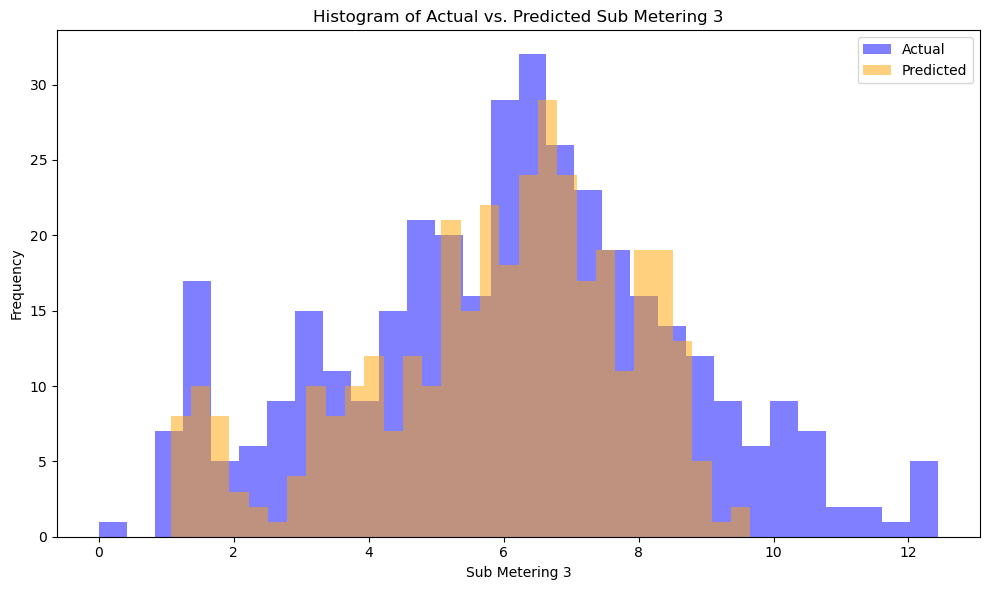

In [43]:
# Visualization: Histograms of Actual and Predicted Global Active Power
plt.figure(figsize=(10, 6))

plt.hist(y_test_metering, bins=30, alpha=0.5, color='blue', label='Actual')

plt.hist(y_pred_metering, bins=30, alpha=0.5, color='orange', label='Predicted')

plt.title('Histogram of Actual vs. Predicted Sub Metering 3')
plt.xlabel('Sub Metering 3')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()